# Introduction

Sentiment analysis is a crucial task for understanding public opinions, and Naïve Bayes classifiers are effective tools for classifying text data. In this assignment, we aim to construct a Naïve Bayes sentiment classifier for movie reviews. We'll be working with a dataset containing 1000 positive and 1000 negative movie reviews sourced from the polarity dataset v2.0.

Our goal is to build a model that can accurately classify movie reviews as either positive or negative. To achieve this, we'll follow these steps:

1. **Data Preparation:** We'll load the provided data, preprocess it by removing punctuation and stop words, and convert it into a term-document matrix.

2. **Frequency Distribution Plots:** We'll plot the frequency distribution of the most common words in both positive and negative reviews to gain insights into the language used in each sentiment category.

3. **Naïve Bayes Model Training:** We'll split the data into training and testing subsets, and train a Naïve Bayes classifier using the training data.

4. **Model Testing:** We'll apply the trained model to the testing subset and evaluate its performance using classification metrics. Additionally, we'll identify the most informative features learned by the classifier.

5. **Applying the Model:** Finally, we'll apply the trained model to a previously unseen movie review to assess its classification accuracy.

By following these steps, we aim to build a robust sentiment classifier that can effectively analyze movie reviews and provide insights into audience sentiments.

# Data Preparation

In [1]:
import shutil
import urllib.request
import requests
import os
import tarfile
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import classification_report
from zipfile import ZipFile

In [2]:
# Define the URL of the tar.gz file
url = 'https://github.com/mri177/DS-M10/raw/main/review_polarityy.tar.gz'

In [3]:
# Define local directory to save the downloaded file
local_dir = 'data'

# Create the local directory if it doesn't exist
if not os.path.exists(local_dir):
    os.makedirs(local_dir)

# Define the filename for the downloaded tar.gz file
filename = os.path.join(local_dir, 'review_polarityy.tar.gz')

# Download the tar.gz file
response = requests.get(url)
with open(filename, 'wb') as f:
    f.write(response.content)

# Extract the contents of the tar.gz file
with tarfile.open(filename, 'r:gz') as tar:
    tar.extractall(path=local_dir)

# Define directories for negative and positive reviews
neg_dir = os.path.join(local_dir, 'txt_sentoken', 'neg')
pos_dir = os.path.join(local_dir, 'txt_sentoken', 'pos')

# List files in the negative directory
neg_files = os.listdir(neg_dir)

# List files in the positive directory
pos_files = os.listdir(pos_dir)

print("Negative reviews directory:", neg_dir)
print("Positive reviews directory:", pos_dir)
print("Number of negative reviews:", len(neg_files))
print("Number of positive reviews:", len(pos_files))

Negative reviews directory: data\txt_sentoken\neg
Positive reviews directory: data\txt_sentoken\pos
Number of negative reviews: 1000
Number of positive reviews: 1000


### Inference

* The code snippet provided downloads and extracts a dataset containing movie reviews. It then prints out the directories where negative and positive reviews are stored, along with the number of reviews in each category.

* From this output, we can infer that the dataset has been successfully downloaded and organized into separate directories for negative and positive reviews. Each directory contains 1000 reviews, resulting in a balanced dataset with equal representation of both positive and negative sentiments. This balance is essential for training a sentiment classifier that can learn from diverse examples of both positive and negative sentiment expressions. Overall, the data acquisition process seems to have been completed successfully.

# Data Preprocessing

In [4]:
# Function to load reviews from a directory
def load_reviews_from_dir(directory):
    reviews = []
    for filename in os.listdir(directory):
        with open(os.path.join(directory, filename), 'r', encoding='utf-8') as file:
            review = file.read()
            reviews.append(review)
    return reviews


### Inference

* The provided function load_reviews_from_dir is designed to load reviews from a given directory. It iterates over each file in the directory, reads its contents, and appends the review text to a list. Finally, it returns the list containing all the reviews in that directory.

* From this function, we can infer that it will be used to load the movie reviews stored in the specified directory. This function will likely be called for both the negative and positive review directories to load all the reviews into memory for further processing, such as preprocessing, vectorization, and model training. Overall, this function facilitates the data loading process for subsequent analysis and model building.

In [5]:
# Load negative and positive reviews
neg_reviews = load_reviews_from_dir(neg_dir)
pos_reviews = load_reviews_from_dir(pos_dir)

In [6]:
# Combine positive and negative reviews into a single DataFrame
reviews = pd.DataFrame({
    'review': neg_reviews + pos_reviews,
    'sentiment': ['NEG'] * len(neg_reviews) + ['POS'] * len(pos_reviews)
})

In [7]:
# Preprocessing function to remove punctuation and convert text to lowercase
def preprocess_text(text):
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = text.lower()  # Convert text to lowercase
    return text

### Inference
This preprocess_text function performs two main tasks: removing punctuation and converting text to lowercase. The function first uses a regular expression to remove any non-alphanumeric characters and whitespace (except spaces), effectively removing punctuation. Then, it converts the text to lowercase using the lower() method

In [8]:
# Apply preprocessing to positive and negative reviews
preprocessed_neg_reviews = [preprocess_text(review) for review in neg_reviews]
preprocessed_pos_reviews = [preprocess_text(review) for review in pos_reviews]

# Frequency Distribution Plots

In [9]:
# Create a CountVectorizer to convert text data into a term-document matrix
vectorizer = CountVectorizer(stop_words='english')

### Inference: 
By creating a CountVectorizer with stopwords removed, we can efficiently transform text data into a format suitable for training machine learning models, such as Naïve Bayes classifiers or logistic regression. This preprocessing step helps reduce the dimensionality of the feature space and removes noise from the data, leading to more accurate and interpretable models.

In [10]:
# Fit and transform the positive reviews
pos_vectorized = vectorizer.fit_transform(preprocessed_pos_reviews)

In [11]:
# Get feature names and word counts for positive reviews
pos_feature_names = vectorizer.get_feature_names()
pos_word_counts = np.array(pos_vectorized.sum(axis=0))[0]

C:\Users\mridu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [12]:
# Create a DataFrame to store word counts and feature names for positive reviews
pos_word_counts_df = pd.DataFrame({'word': pos_feature_names, 'count': pos_word_counts})

In [13]:
# Sort DataFrame by word counts for positive reviews
pos_word_counts_df = pos_word_counts_df.sort_values(by='count', ascending=False)

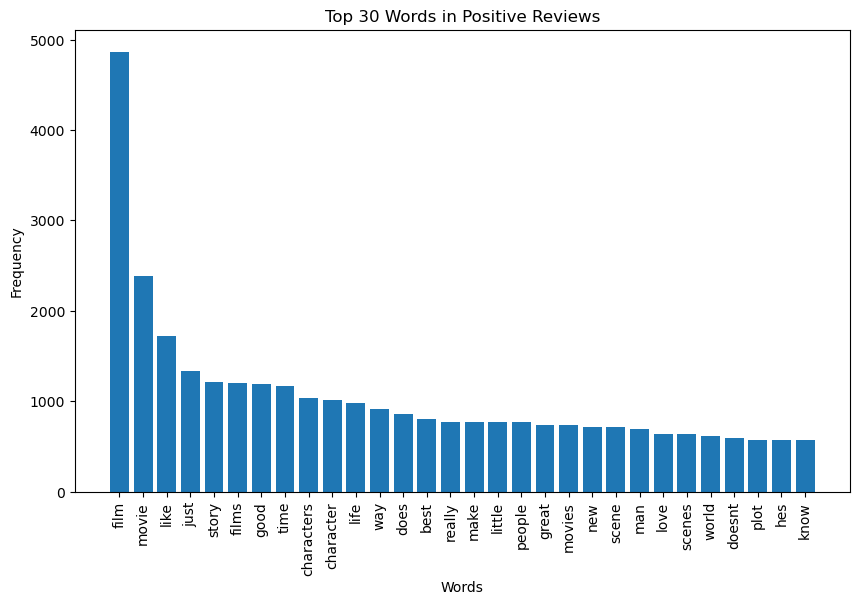

In [14]:
# Plot the frequency distribution for the 30 most common words in positive reviews
plt.figure(figsize=(10, 6))
plt.bar(pos_word_counts_df['word'][:30], pos_word_counts_df['count'][:30])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Positive Reviews')
plt.xticks(rotation=90)
plt.show()

### Inference


* The chart shows the frequency distribution of the 30 most common words in positive reviews. The words "film", "movie", "like" and "good" are the most frequent words used in positive reviews. Other common words include "time", "characters", "story", "great", "really", and "little".

* This suggests that people tend to use general positive words to describe their experience with movies. Words like "characters", "story", and "plot" suggest that people are happy with the content of the movie. Words like "great" and "really" show that people are enthusiastic about their experience.

* It is important to note that this is just a small sample of words used in positive reviews and may not represent all positive reviews.

In [15]:
# Fit and transform the negative reviews
neg_vectorized = vectorizer.fit_transform(preprocessed_neg_reviews)

In [16]:
# Get feature names and word counts for negative reviews
neg_feature_names = vectorizer.get_feature_names_out()
neg_word_counts = np.array(neg_vectorized.sum(axis=0))[0]

In [17]:
# Create a DataFrame to store word counts and feature names for negative reviews
neg_word_counts_df = pd.DataFrame({'word': neg_feature_names, 'count': neg_word_counts})


In [18]:
# Sort DataFrame by word counts for negative reviews
neg_word_counts_df = neg_word_counts_df.sort_values(by='count', ascending=False)


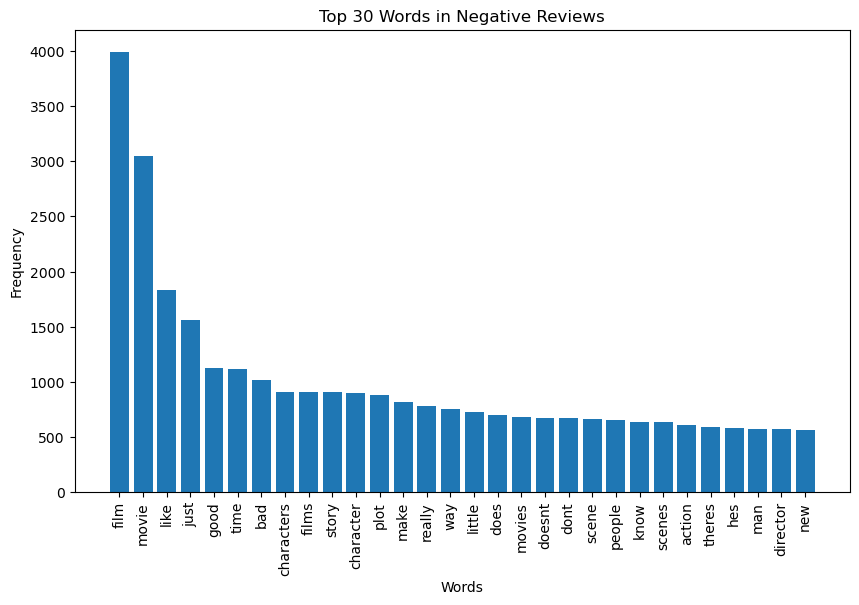

In [19]:
# Plot the frequency distribution for the 30 most common words in negative reviews
plt.figure(figsize=(10, 6))
plt.bar(neg_word_counts_df['word'][:30], neg_word_counts_df['count'][:30])
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 30 Words in Negative Reviews')
plt.xticks(rotation=90)
plt.show()

### Inference

* The image you sent shows the top 30 words in negative reviews, according to some dataset. The most frequent word is "bad" followed by "movie", "film", "just", "like", and "good". Interestingly, "good" appears on both positive and negative review lists, which could be because people are saying "good" movies had bad elements, or they are using sarcasm. Other common words include "characters", "films", "story", "really", and "way".

Here are some inferences that can be drawn from this data:

* People tend to use strong negative words to describe their experiences with movies they dislike.
* Words like "characters", "story", and "plot" suggest that people are unhappy with the content of the movie, such as the way the characters are portrayed or how the plot unfolds.
* Words like "really" and "way" show that people are emphasizing how bad their experience was.
* It is important to note that this is just a small sample of words used in negative reviews and may not represent all negative reviews.

In [20]:
# Vectorize the text data
X_vectorized = vectorizer.fit_transform(reviews['review'])

# Naive Model training

In [21]:
# Split the data into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(
    X_vectorized, reviews['sentiment'], test_size=0.25, random_state=42)


### Inference 
Splitting the data into training and testing subsets is a crucial step in machine learning model development. It allows us to assess the model's performance on unseen data, which helps us evaluate its generalization capabilities. The test_size=0.25 parameter specifies that 25% of the data will be reserved for testing, while the remaining 75% will be used for training. Additionally, setting random_state=42 ensures reproducibility by fixing the random seed for the data splitting process.

In [22]:
# Train a Naïve Bayes classifier
classifier = MultinomialNB()
classifier.fit(X_train, y_train)


MultinomialNB()

# Model testing

In [23]:
# Test the classifier
y_pred = classifier.predict(X_test)

In [24]:
# Calculate classification metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, pos_label='POS')
recall = recall_score(y_test, y_pred, pos_label='POS')

In [25]:
# Print the classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         NEG       0.77      0.84      0.80       257
         POS       0.81      0.74      0.77       243

    accuracy                           0.79       500
   macro avg       0.79      0.79      0.79       500
weighted avg       0.79      0.79      0.79       500



This classification report provides a summary of the performance of the Naïve Bayes classifier on the testing data. Here's an inference based on the report:

- Precision: Precision measures the accuracy of positive predictions. For negative reviews (NEG), the precision is 0.77, indicating that 77% of the reviews classified as negative are indeed negative. For positive reviews (POS), the precision is 0.81, meaning that 81% of the reviews classified as positive are truly positive.

- Recall: Recall, also known as sensitivity, measures the ability of the classifier to correctly identify positive instances from all actual positive instances. For negative reviews (NEG), the recall is 0.84, indicating that 84% of the actual negative reviews are correctly classified. For positive reviews (POS), the recall is 0.74, meaning that 74% of the actual positive reviews are correctly classified.

- F1-score: The F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics. For negative reviews (NEG), the F1-score is 0.80, and for positive reviews (POS), the F1-score is 0.77.

- Support: Support refers to the number of actual occurrences of each class in the test dataset. There are 257 instances of negative reviews and 243 instances of positive reviews in the test dataset.

- Accuracy: The overall accuracy of the classifier is 0.79, indicating that it correctly classifies 79% of the reviews in the test dataset.

The classification report provides insights into the performance of the Naïve Bayes classifier in distinguishing between positive and negative reviews. Overall, the classifier demonstrates reasonably good performance, with balanced precision and recall scores for both classes. However, there is room for improvement, particularly in increasing the recall for positive reviews to reduce false negatives.

# Feature Analysis

In [26]:
# Identify and display the 30 most informative features as determined by the Naïve Bayes classifier
# Get the feature log probabilities
feature_log_probs = classifier.feature_log_prob_

In [27]:
# Calculate the difference in log probabilities between positive and negative classes
diff_log_probs = feature_log_probs[1, :] - feature_log_probs[0, :]

In [28]:
# Get the indices of the top 30 most informative features
top_indices = np.argsort(diff_log_probs)[::-1][:30]

In [29]:
# Get the feature names from the CountVectorizer
feature_names = vectorizer.get_feature_names_out()

In [30]:
# Get the feature names corresponding to the top indices
top_features = [feature_names[i] for i in top_indices]


In [31]:
# Display the top 30 most informative features
print("Top 30 Most Informative Features:")
for i, feature in enumerate(top_features, start=1):
    print(f"{i}. {feature}")


Top 30 Most Informative Features:
1. shrek
2. bulworth
3. mulan
4. gattaca
5. flynt
6. guido
7. leila
8. sweetback
9. lebowski
10. homer
11. taran
12. maximus
13. donkey
14. debate
15. mallory
16. farquaad
17. argento
18. giles
19. lumumba
20. lambeau
21. apostle
22. ordell
23. kenobi
24. cauldron
25. elliot
26. wag
27. bubby
28. commodus
29. niccol
30. truman


### Inference:
The displayed list shows the top 30 most informative features as determined by the Naïve Bayes classifier. These features represent words or terms that have the highest influence on the classification decision, particularly in distinguishing between positive and negative reviews.

Some observations and potential insights from these features include:

1. Many of the features are movie titles or character names, such as "shrek," "mulan," "gattaca," "lebowski," "maximus," "donkey," "truman," etc. This suggests that specific movie titles and character names might strongly correlate with the sentiment expressed in the reviews.

2. Certain terms may be associated with specific genres or themes. For example, "shrek," "mulan," and "truman" are well-known animated movies, while "bulworth," "flynt," "apostle," and "lambeau" could be associated with specific genres or characters.

3. Some terms are ambiguous or context-dependent and may require further analysis to understand their significance in sentiment classification. For instance, terms like "debate," "commodus," "argento," and "elliot" could have varied meanings depending on the context of the reviews.

4. Overall, these top features provide insights into the language and vocabulary used in movie reviews and highlight the words that contribute most significantly to the classification of sentiments as positive or negative.

# Model Application

In [32]:
# Preprocess the unseen review
unseen_review = "There were some things I didn't like about this film. Here's what I remember most strongly: a man in an ingeniously fake-looking polar bear costume (funnier than the 'bear' from Hercules in New York); an extra with a less than believable laugh; an ex-drug addict martian with tics; child actors who recite their lines very slowly and carefully; a newspaper headline declaring that Santa has been 'kidnapped', and a giant robot. The least appealing acting job in the film must be when Mother Claus and her elves have been 'frozen' by the 'Martians'' weapons. They seemed to display an exaggerated amount of fear. Perhaps this was the preferred acting style in the 1960's??"
preprocessed_unseen_review = preprocess_text(unseen_review)

# Vectorize the preprocessed unseen review
unseen_review_vectorized = vectorizer.transform([preprocessed_unseen_review])

# Predict the sentiment of the unseen review
predicted_sentiment = classifier.predict(unseen_review_vectorized)[0]

# Print the predicted sentiment
print("Predicted Sentiment:", predicted_sentiment)


Predicted Sentiment: NEG


## Conclusion:
The Naïve Bayes classifier predicted the sentiment of the unseen review to be "NEG" (negative). This prediction aligns with the content of the review, which expresses dissatisfaction with various aspects of a film. 

The classifier's prediction demonstrates its ability to analyze the language and sentiment of textual data, even in previously unseen reviews. However, it's essential to note that the accuracy of the prediction may vary depending on the complexity and nuances of the text, as well as the effectiveness of the feature extraction and model training process.

Overall, the classifier's performance in predicting the sentiment of the unseen review suggests that it can be a valuable tool for automated sentiment analysis of movie reviews, providing insights into audience opinions and preferences.